In [13]:
!pip install -q -r requirements.txt

In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

In [23]:
df = pd.read_csv('/Users/kanishka/Zuu/week3/data/processed/aOvRUrcRLE.csv')
df.head()

,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreBins
0,France,Female,3.76120,2,0.00,1,1,1,101348.88,1,Fair
1,Spain,Female,3.73767,1,83807.86,1,0,1,112542.58,0,Fair
2,France,Female,3.76120,8,159660.80,3,1,0,113931.57,1,Poor
3,France,Female,3.68668,1,0.00,2,0,0,93826.63,0,Good
4,Spain,Female,3.78419,2,125510.82,1,1,1,79084.10,0,Excellent


### Build scikit-learn pipeline

In [9]:
reminder_features = ["NumOfProducts", "HasCrCard", "IsActiveMember", "Exited"]
numerical_features = ["Age", "Tenure", "Balance", "EstimatedSalary"] 
nominal_features = ["Gender", "Geography"]
ordinal_features = ["CreditScoreBins"]

numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(
            strategy='median'
        )),
        ('scaler', StandardScaler())
    ]
)

nominal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(
            strategy='constant',
            fill_value='missing'
        )),
        ('encoder', OneHotEncoder())
    ]
)

ordinal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(
            strategy='constant',
            fill_value='missing'
        )),
        ('encoder', OrdinalEncoder())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer, ordinal_features)
    ],
    remainder='drop'
)

nominal_feature_names = []
for feature in nominal_features:
    unique_values = df[feature].unique()
    nominal_feature_names.extend([f"{feature}_{val}" for val in unique_values])

df_cp = df.copy()
df_transformed = pd.DataFrame(
    preprocessor.fit_transform(df_cp),
    columns=numerical_features + nominal_feature_names + ordinal_features,
    index=df_cp.index
)
df_remainder = df[reminder_features]
df_pp = pd.concat([df_transformed, df_remainder], axis=1)

In [10]:
df_pp

,Age,Tenure,Balance,EstimatedSalary,Gender_Female,Gender_Male,Geography_France,Geography_Spain,Geography_Germany,CreditScoreBins,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,0.428433,-1.041526,-1.225704,0.021852,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1,1
1,0.332317,-1.387294,0.117331,0.216474,1.0,0.0,0.0,0.0,1.0,1.0,1,0,1,0
2,0.428433,1.033083,1.332886,0.240624,1.0,0.0,1.0,0.0,0.0,3.0,3,1,0,1
3,0.124038,-1.387294,-1.225704,-0.108935,1.0,0.0,1.0,0.0,0.0,2.0,2,0,0,0
4,0.522339,-1.041526,0.785627,-0.365260,1.0,0.0,0.0,0.0,1.0,0.0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,0.133021,-0.004221,-1.225704,-0.066442,0.0,1.0,1.0,0.0,0.0,4.0,2,1,0,0
9989,-0.297349,1.724620,-0.306347,0.027953,0.0,1.0,1.0,0.0,0.0,3.0,1,1,1,0
9990,-0.185431,0.687315,-1.225704,-1.008543,1.0,0.0,1.0,0.0,0.0,2.0,1,0,1,1
9991,0.428433,-0.695758,-0.022610,-0.125246,0.0,1.0,0.0,1.0,0.0,4.0,2,1,0,1


In [11]:
df_pp.to_csv('/Users/kanishka/Zuu/week3/data/processed/x_transformed.csv', index=False)

### 3. Handle Imbalance

In [18]:
X = df_pp.drop(columns=['Exited'])
Y = df_pp['Exited']

In [19]:
""" 
churn - 1000
non-churn - 9000

unsample - (churn) 1000 -> 9000
downsampling - (non-churn) 9000 -> 1000

"""

X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size=0.2,
    random_state=42,
)

In [20]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

Text(0, 0.5, 'Count')

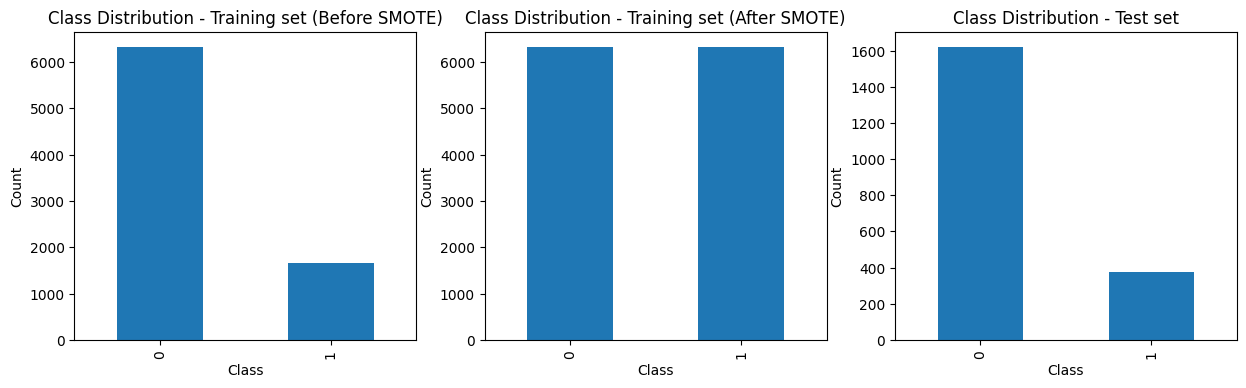

In [25]:
plt.figure(figsize=(15, 4))

#bofore smote
plt.subplot(131)
Y_train.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training set (Before SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

#after smote
plt.subplot(132)
Y_train_resampled.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training set (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count') 

#test set
plt.subplot(133)
Y_test.value_counts().plot(kind='bar')
plt.title('Class Distribution - Test set')
plt.xlabel('Class')
plt.ylabel('Count')


In [27]:
np.savez('artifacts/X_train.npz', X_train_resampled)
np.savez('artifacts/Y_train.npz', Y_train_resampled)
np.savez('artifacts/X_test.npz', X_test)
np.savez('artifacts/Y_test.npz', Y_test)